<a href="https://colab.research.google.com/github/chandan2311/Facial-Expression_recognition-Pytorch/blob/main/Facial_Expression_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052
Receiving objects: 100% (34052/34052), 52.31 MiB | 31.14 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gyarmc8t
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gyarmc8t
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
Image_train_folder='/content/Facial-Expression-Dataset/train'
Valid_img_folder='/content/Facial-Expression-Dataset/validation'

LR=0.001
BATCH_SIZE=32
EPOCHS=15

DEVICE='cuda'
MODEL_NAME='efficentnet_b0'

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_aug=T.Compose([T.RandomHorizontalFlip(p=0.5),T.RandomRotation(degrees=(-20,+20)),T.ToTensor()])
valid_aug=T.Compose([T.ToTensor()])

In [ ]:
trainset=ImageFolder(Image_train_folder,transform=train_aug)
validset=ImageFolder(Valid_img_folder,transform=valid_aug)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

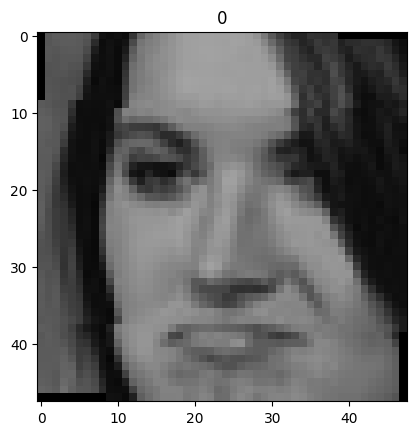

In [ ]:
image,label=trainset[35]
plt.imshow(image.permute(1,2,0))
plt.title(label)

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images,labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel,self).__init__()

    self.eff_net=timm.create_model('efficientnet_b0',pretrained=True,num_classes=7)
  def forward(self,images,labels=None):
    logits=self.eff_net(images)

    if labels!=None:
      loss =nn.CrossEntropyLoss()(logits,labels)
      return logits,loss
    return logits

In [ ]:
model = FaceModel()
model.to(DEVICE);

In [ ]:
from tqdm import tqdm


In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model,dataloader,optimizer,current_epo):
  model.train()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader,desc="EPOCH"+"[TRAIN]"+str(current_epo+1)+"/"+str(EPOCHS))

  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(DEVICE),labels.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,labels)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})

  return total_loss/len(dataloader),total_acc/ len(dataloader)

In [ ]:
def eval_fn(model,dataloader,current_epo):
  model.eval()
  total_loss=0.0
  total_acc=0.0
  tk=tqdm(dataloader,desc="EPOCH"+"[VALID]"+str(current_epo+1)+"/"+str(EPOCHS))

  for t,data in enumerate(tk):
    images,labels=data
    images,labels=images.to(DEVICE),labels.to(DEVICE)


    logits,loss=model(images,labels)



    total_loss +=loss.item()
    total_acc+=multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})
  return total_loss/len(dataloader),total_acc/  len(dataloader)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss,train_acc=train_fn( model,trainloader,optimizer,i)
  valid_loss,valid_acc=eval_fn(model,validloader,i)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss=valid_loss

EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:06<00:00, 35.66it/s, loss=1.603758, acc=0.504906]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:05<00:00, 39.08it/s, loss=1.198721, acc=0.555745]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 36.51it/s, loss=1.129666, acc=0.579925]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 36.35it/s, loss=1.081823, acc=0.590171]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:05<00:00, 38.93it/s, loss=1.067358, acc=0.601364]


SAVED-BEST-WEIGHTS


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:05<00:00, 39.17it/s, loss=1.007277, acc=0.618028]


SAVED-BEST-WEIGHTS


EPOCH[VALID]12/15: 100%|██████████| 221/221 [00:05<00:00, 39.54it/s, loss=0.981660, acc=0.642980]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:05<00:00, 40.09it/s, loss=1.023801, acc=0.628600]


In [ ]:
def view_classify(img,ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes,ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

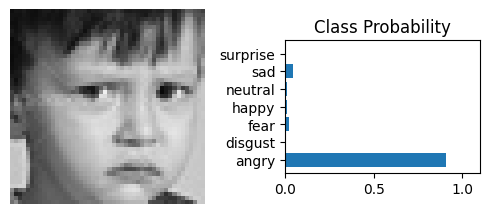

In [ ]:
image, label = validset[98]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)

view_classify(image.squeeze(), probs)